In [ ]:
from src.v1.symbolic import Var, Par
from src.v2.units import ureg
from graph.graphutils import namefromsympy
from src.v3.nesting import Model, adda, addsolver, addobj, addeq, OPT, setsolvefor, evalexpr
from graph.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from src.v2.workflow_mdao import mdao_workflow_with_args
from src.v2.mdaobuild import build_archi
from src.v2.postprocess import print_outputs, print_inputs, update_varval
import openmdao.api as om
import numpy as np
import sympy as sp

In [2]:
ureg.define('USD = [currency] ')

# Variables and parameters 
They are shared accross models

In [3]:
P_t = Var('P_c', unit='W', forceunit=True)
Pbus = Var('P_b', unit='W', forceunit=True)
S = Var('h', 400, unit='km')
D = Var('D', 0.1, unit='m')
A = Var('A', 0.5, unit='m^2')
eta_t = Par(r'\eta_t', 0.16)
eta_a = Par(r'\eta', 0.5)
alpha = Par(r'\alpha', 1e20, 'bits/W')
th = Par(r'\theta', np.pi/4)
W0 = Par('W_0', 1367, 'W/m^2')
Re = Par('Re', 6378, 'km')
μ = Par('mu', 3.986005e14, 'm^3/s^2')
c1 = Par('c_1', 2500, 'USD/m^2')
c2 = Par('c_2', 12000, 'USD/m^2')
c3 = Par('c_3', 100, 'USD/W')
c4 = Par('c_4', 12000, 'USD')

# Formulation 1

In [4]:
model = Model(solver=OPT)
m = model.root
s2 = addsolver(m)#, solvefor=['Pbus', 'P_t'])
adda(s2, P_t, A*eta_a*W0*sp.cos(th)-Pbus)
adda(s2, Pbus, 10*abs(P_t)**0.5)
R = adda(m, 'R', alpha*P_t*D**2*eta_t/(16*S**2), unit='MB/s', forceunit=True)
C = adda(m, 'C', c1*D**2+c2*A+c3*Pbus+c4, unit='kUSD')
addeq(m, -R+1) # == 0
addobj(m, C)

In [5]:
evalexpr(alpha*eta_t/(16)).varval, evalexpr(eta_a*W0*sp.cos(th)).varval

(array(1.e+18), array(483.30748494))

In [6]:
setsolvefor(m, [D,A], {D:[0.5,10], A:[0.04,1]})

In [7]:
edges, tree = model.generate_formulation()

In [8]:
Ein, Eout, Rin = edges

In [9]:
from graph.matrixview import render_incidence

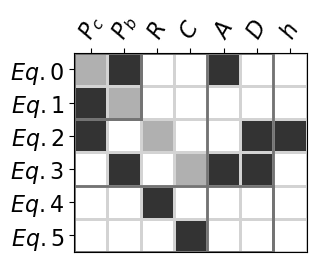

In [10]:
Ein_noparam = {comp:tuple(var for var in compvars if not model.idmapping[var].always_input) for comp,compvars in Ein.items()}
edges_noparam = Ein_noparam, Eout, Rin
_, ax = render_incidence(edges_noparam, tree, rawvarname=True, figsize=(3,3))

### Build openMDAO model

In [11]:
ordered_tree, ordered_edges = tree, edges
comp_options, var_options, solvers_options = model.comp_options, model.var_options, model.solvers_options
solvers_options[1].update({'optimizer': 'SLSQP'})
solvers_options[2] = {'solver': 'N', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromsympy(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [12]:
components

[(('A', 'W_0', 'P_b', '\\theta', '\\eta'), 0, ('P_c',), 'W_0*\\eta*A*cos(\\theta) - P_b'),
 (('P_c',), 1, ('P_b',), '10*Abs(P_c)**0.5'),
 (('\\alpha', 'P_c', 'h', '\\eta_t', 'D'), 2, ('R',), '\\alpha*\\eta_t*D**2*P_c/(16*h**2)'),
 (('A', 'c_4', 'c_2', 'P_b', 'c_1', 'c_3', 'D'), 3, ('C',), 'c_1*D**2 + c_2*A + c_3*P_b + c_4'),
 (('R',), 4, (None,), '1 - R'),
 (('C',), 5, (None,), 'C')]

In [13]:
components[0].graddict({th:th.varval, Pbus:10, eta_a:eta_a.varval, A:10, W0:W0.varval})

{(P_c, A): DeviceArray(483.30748494, dtype=float64),
 (P_c, W_0): DeviceArray(3.53553391, dtype=float64),
 (P_c, P_b): DeviceArray(-1., dtype=float64),
 (P_c, \theta): DeviceArray(-4833.07484941, dtype=float64),
 (P_c, \eta): DeviceArray(9666.14969882, dtype=float64)}

In [14]:
components[2].graddict({eta_t:eta_t.varval, alpha:alpha.varval, D:10, P_t:10, S:S.varval})

{(R, \alpha): DeviceArray(7.8125e-18, dtype=float64),
 (R, P_c): DeviceArray(78.125, dtype=float64),
 (R, h): DeviceArray(-3.90625, dtype=float64),
 (R, \eta_t): DeviceArray(4882.8125, dtype=float64),
 (R, D): DeviceArray(156.25, dtype=float64)}

In [15]:
components[3].graddict({c1:c1.varval, D:10, c3:c3.varval, Pbus:10, c4:c4.varval, A:10, c2:c2.varval})

{(C, A): DeviceArray(12., dtype=float64),
 (C, c_4): DeviceArray(0.001, dtype=float64),
 (C, c_2): DeviceArray(0.01, dtype=float64),
 (C, P_b): DeviceArray(0.1, dtype=float64),
 (C, c_1): DeviceArray(0.1, dtype=float64),
 (C, c_3): DeviceArray(0.01, dtype=float64),
 (C, D): DeviceArray(50., dtype=float64)}

In [16]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [17]:
prob.set_val('D', 0.67)
prob.set_val('A', 0.1)

In [18]:
prob.run_model();


==
s2
==
NL: Newton Converged in 5 iterations


In [19]:
print_outputs(model, prob, namingfunc, rounding=3)

$$P_c$$,12.697,W
$$P_b$$,35.633,W
$$R$$,4.453,MB/s
$$C$$,17.886,kUSD


In [20]:
print_inputs(model, prob, namingfunc, mdao_in)

$$A$$,0.1,m²
$$h$$,400,km
$$D$$,0.67,m


In [21]:
prob.run_driver();


==
s2
==
NL: Newton Converged in 0 iterations

==
s2
==
NL: Newton Converged in 0 iterations

==
s2
==
NL: Newton Converged in 0 iterations

==
s2
==
NL: Newton Converged in 5 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 2 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.300923260384632
            Iterations: 8
            Function evaluations: 9
            Gradient evaluations: 7
Optimization Complete
-----------------------------------


In [22]:
print_inputs(model, prob, namingfunc, mdao_in)

$$A$$,0.041,m²
$$h$$,400,km
$$D$$,0.67,m


In [23]:
print_outputs(model, prob, namingfunc, rounding=1)

$$P_c$$,2.8,W
$$P_b$$,16.9,W
$$R$$,1,MB/s
$$C$$,15.3,kUSD


In [18]:
recorder = om.SqliteRecorder('cases2.sqlite')

In [19]:
prob.model.s2.add_recorder(recorder)
for key,val in ordered_tree[0].items():
    s = groups[namingfunc(val, SOLVER)]
    f = getattr(s, namingfunc(key, COMP))
    f.recording_options['options_excludes'] = ['component']

In [21]:
prob.cleanup();

In [30]:
update_varval(model, prob, namingfunc)

In [31]:
evalexpr(10*P_t**0.5)

dummy

# Formulation 2: restructured

In [32]:
modelrstr = Model(solver=OPT)
mrstr = modelrstr.root
R = Var('R', unit='MB/s')
adda(mrstr, P_t, R/(alpha*D**2*eta_t)*(16*S**2))
adda(mrstr, Pbus, 10*P_t**0.5)
adda(mrstr, A, (Pbus+P_t)/(eta_a*W0*sp.cos(th)))
C = adda(mrstr, 'C', c1*D**2+c2*A+c3*Pbus+c4, unit='kUSD')
addobj(mrstr, C)

In [33]:
setsolvefor(mrstr, [D], {D:[0,10]})

In [34]:
edges, tree = modelrstr.generate_formulation()

In [35]:
ordered_tree, ordered_edges = tree, edges
comp_options,var_options,solvers_options = modelrstr.comp_options, modelrstr.var_options, modelrstr.solvers_options
nodetyperepr = modelrstr.nametyperepr
namingfunc = namefromsympy(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)
components = modelrstr.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [36]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, modelrstr.idmapping)

In [37]:
R.varval = 1
prob.set_val('R', 1.003)
#D.varval = 0.001
#prob.set_val('D', 0.43057)

In [38]:
prob.run_model()

In [39]:
prob.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.304291583353413
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 5
Optimization Complete
-----------------------------------


In [41]:
print_inputs(modelrstr, prob, namingfunc, mdao_in)

$$R$$,1.003,MB/s
$$h$$,400,km
$$D$$,0.671,m


In [43]:
print_outputs(modelrstr, prob, namingfunc, rounding=3)

$$P_c$$,2.853,W
$$P_b$$,16.891,W
$$A$$,0.041,m²
$$C$$,15.304,kUSD
